In [1]:
import torch

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["image.cmap"] = "magma"

### 1. Create the training data set

In [2]:
train_x = torch.tensor(
    [
        [1 / 2, 1 / 2, 0, 0],
        [1 / 3, 1 / 3, 1 / 3, 0],
        [0, 1 / 2, 1 / 2, 0],
        [0, 1 / 3, 1 / 3, 1 / 3],
    ]
)

train_y = torch.tensor([192.08, 258.30, 187.24, 188.54])

### 2. Normalize the labels

In [3]:
# normalize the labels
train_y = (train_y - train_y.mean()) / train_y.std()
train_y

tensor([-0.4183,  1.4974, -0.5583, -0.5207])

### 3. Train a Gaussian process

In [4]:
import gpytorch


class BaseGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:
# declare the GP
lengthscale = 1
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = BaseGPModel(train_x, train_y, likelihood)

# fix the hyperparameters
model.covar_module.lengthscale = lengthscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

### 4. create the test data

In [6]:
grid_x = torch.linspace(0, 1, 101)

grid_x1, grid_x2 = torch.meshgrid(grid_x, grid_x, indexing="ij")
xs = torch.vstack(
    [
        grid_x1.flatten(),  # 1st column
        grid_x2.flatten(),  # 2nd column
        torch.zeros(101 ** 2),  # 3rd column, assumed to be 0
        torch.zeros(101 ** 2),  # 4th column, assumed to be 0
    ]
).transpose(-1, -2)

xs

tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0100, 0.0000, 0.0000],
        [0.0000, 0.0200, 0.0000, 0.0000],
        ...,
        [1.0000, 0.9800, 0.0000, 0.0000],
        [1.0000, 0.9900, 0.0000, 0.0000],
        [1.0000, 1.0000, 0.0000, 0.0000]])

### 5. Make predictions

In [7]:
with torch.no_grad():
    predictive_distribution = likelihood(model(xs))
    predictive_mean = predictive_distribution.mean
    predictive_stddev = predictive_distribution.stddev

### 6. Visualize the predictions

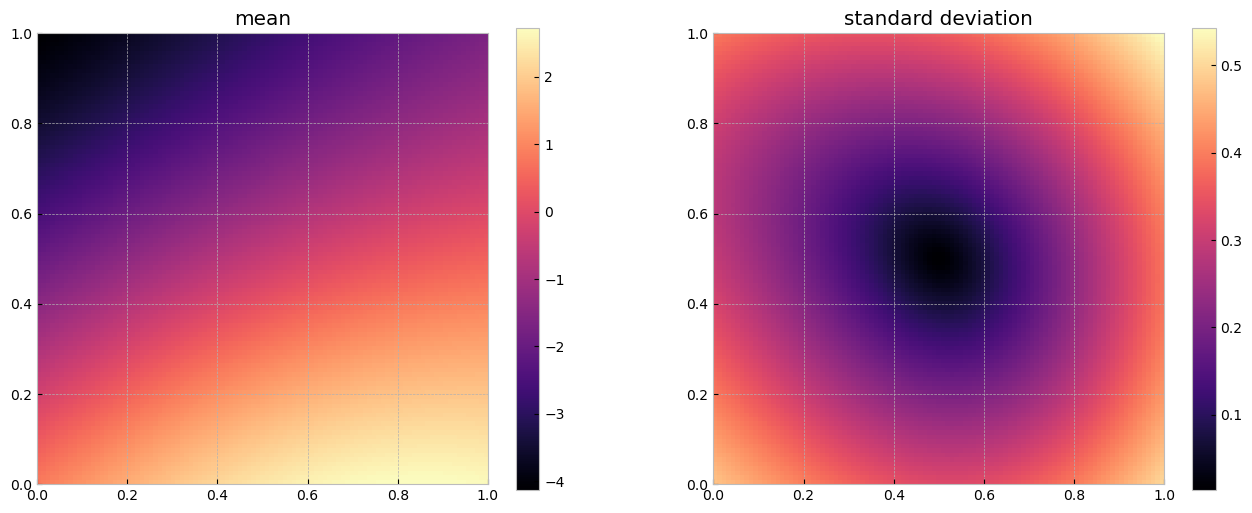

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

c = ax[0].imshow(
    predictive_mean.detach().reshape(101, 101).transpose(-1, -2),
    origin="lower",
    extent=[0, 1, 0, 1],
)
plt.colorbar(c, ax=ax[0])

ax[0].set_title("mean")

c = ax[1].imshow(
    predictive_stddev.detach().reshape(101, 101).transpose(-1, -2),
    origin="lower",
    extent=[0, 1, 0, 1],
)
plt.colorbar(c, ax=ax[1])

ax[1].set_title("standard deviation")

plt.show()